# Modeling Process

In [1]:
# Utils.models contains all libraries needed
from utils.models import *
import os

In [2]:
# notebook parameters

models_path = '../models'
data_path = '../data'
output_path = '../outputs'
filename_data = 'clean-dataset'

In [3]:
try:
    os.makedirs(f"{models_path}/features_by_models")
except FileExistsError:
    # directory already exists
    pass

try:
    os.makedirs(f"{models_path}/features_scores_models")
except FileExistsError:
    # directory already exists
    pass

In [4]:
# load data
data = pd.read_csv(f"{data_path}/{filename_data}.csv")
print('This dataset has shape: ', data.shape)
data.head()

This dataset has shape:  (30000, 42)


,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,...,PAY_TO_BILL_5,PAY_TO_BILL_6,PAY_AMOUNT_STD_LAST_6M,BILL_AMOUNT_STD_LAST_6M,AGE_<=40,AGE_<=60,AGE_<=80,RISKY_GROUP1,RISKY_GROUP2,RISKY_GROUP3
0,20000,2,2,-1,-1,-2,-2,3913,3102,689,...,0.000000,0.000000,281.283072,1761.633219,1,0,0,1,0,1
1,120000,-1,2,0,0,0,2,2682,1725,2682,...,0.000000,0.613121,752.772653,637.967841,1,0,0,1,0,1
2,90000,0,0,0,0,0,0,29239,14027,13559,...,0.066894,0.321543,1569.815488,6064.518593,1,0,0,1,0,1
3,50000,0,0,0,0,0,0,46990,48233,49291,...,0.036913,0.033843,478.058155,10565.793518,1,0,0,1,0,1
4,50000,-1,0,-1,0,0,0,8617,5670,35835,...,0.035985,0.035490,13786.230736,10668.590074,0,1,0,0,1,0


***
### Selecting features


In [5]:
X, y = preprocess(data, 'dpnm')

n_colums = X.shape[1]
min_cols= 30 # minimum quantity of features to try in Selectkbest

In [6]:
# init models

tree = DecisionTreeClassifier()
sgd = SGDClassifier(loss='log')
lr = LogisticRegression(solver = 'lbfgs')
svc = SVC()
rf = RandomForestClassifier()
xgboost = xgb.XGBClassifier()
naive = GaussianNB()
knn = KNeighborsClassifier()
ada = AdaBoostClassifier()

classifiers = [tree,sgd, lr, svc, rf, xgboost, naive, knn, ada]

In [7]:
for clf in tqdm(classifiers):
    # perform selection of features by model
    features_names, features_scores, artifact_name = select_k_variables(clf, X, y, n_colums, min_cols)
    # saving features used by model
    save_features_name(features_names, models_path, artifact_name)
    # saving features used with important scores
    features_scores.to_csv(f"{models_path}/features_scores_models/{artifact_name}.csv", index=False)

100%|██████████| 9/9 [1:12:29<00:00, 483.33s/it]  


Model DecisionTreeClassifier works with 25 features
---------------------------------------
DecisionTreeClassifier_0.73 saved successfully!
Model SGDClassifier works with 24 features
---------------------------------------
SGDClassifier_0.78 saved successfully!
Model LogisticRegression works with 17 features
---------------------------------------
LogisticRegression_0.78 saved successfully!
Model SVC works with 41 features
---------------------------------------
SVC_0.78 saved successfully!
Model RandomForestClassifier works with 27 features
---------------------------------------
RandomForestClassifier_0.81 saved successfully!
Model XGBClassifier works with 17 features
---------------------------------------
XGBClassifier_0.82 saved successfully!
Model GaussianNB works with 15 features
---------------------------------------
GaussianNB_0.34 saved successfully!
Model KNeighborsClassifier works with 28 features
---------------------------------------
KNeighborsClassifier_0.76 saved succ

***
### Training Models

#### Apply SMOTE to get a balanced dataset

In [7]:
# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [8]:
# Apply resampling method to training data
resample = BorderlineSMOTE()
X_train_resampled, y_train_resampled = resample.fit_resample(X_train, y_train)

print('Dimension of training set before resampling: ', X_train.shape)
print('Dimension of training set after resampling: ', X_train_resampled.shape)


Dimension of training set before resampling:  (20953, 41)
Dimension of training set after resampling:  (32572, 41)


In [9]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers',
                                     'auc',
                                     'best_params',
                                     'best_score',
                                     'n_features'])

In [10]:
classifiers = [
    {"Model":rf,
        "params":{'max_depth': [7,8],
                  'max_features': [7,8],
                  'n_estimators': [60,70]}},
    {"Model":knn,
        "params":{"n_neighbors":[2,3],
                  'algorithm':['auto', 'ball_tree']}},
    {"Model":xgboost,
        "params":{'max_depth': [7,11],
                  'learning_rate':[0.2,0.5],
                  'eval_metric':['mlogloss']}},
    {"Model":ada,
        "params":{'n_estimators':[60,70],
                  'learning_rate':[0.05, 0.01, 0.1]}},
    {"Model":svc,
        "params":{'kernel':['linear', 'poly', 'rbf'],
                  'C':[0.05, 0.01, 0.1],
                  'gamma':[0.05, 0.01, 0.1]}},
    {"Model":lr,
        "params":{'penalty':['l2'],
                  'C':[100,10,1]}}
]

  0%|          | 0/6 [01:55<?, ?it/s]


Training RandomForestClassifier-v1:
This model uses 27 features
F1 score in training is: 0.8138577387050805
Best params in training are: {'max_depth': 8, 'max_features': 8, 'n_estimators': 60}
Classifier in testing:  RandomForestClassifier
              precision    recall  f1-score   support

  No Default       0.86      0.91      0.88      7020
     Default       0.59      0.46      0.51      1960

    accuracy                           0.81      8980
   macro avg       0.72      0.68      0.70      8980
weighted avg       0.80      0.81      0.80      8980

---------------------------------------------------------
Model RandomForestClassifier-v1.pkl saved successfully
ROC Curve of model RandomForestClassifier-v1.png saved successfully


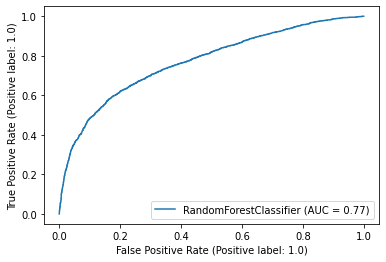

In [11]:
version = 'v1'
features_path = '../models/features_by_models'
for clf in tqdm(classifiers):
    estimator = clf['Model']
    param_grid = clf['params']
    name_model = estimator.__class__.__name__
    # get features names for model
    columns = get_columns_model(name_model, features_path)
    # use best features for models
    X_train_filtered = X_train_resampled[columns]
    X_test_filtered = X_test[columns]
    # training process
    fpr, tpr, auc, best_params, best_score = train_model(estimator,
                                                         param_grid,
                                                         X_train_filtered,
                                                         y_train_resampled,
                                                         X_test_filtered,
                                                         y_test,
                                                         models_path,
                                                         output_path,
                                                         version)

    result_table = result_table.append({
        'classifiers': f"{name_model}-{version}",
        'auc': auc,
        'best_params': best_params,
        'best_score': best_score,
        'n_features': X_train_filtered.shape[1]},ignore_index=True)

    break

In [ ]:
version = 'v2'
for clf in tqdm(classifiers):
    estimator = clf['Model']
    param_grid = clf['params']
    name_model = estimator.__class__.__name__
    # training process
    fpr, tpr, auc, best_params, best_score = train_model(estimator,
                                                         param_grid,
                                                         X_train_resampled,
                                                         y_train_resampled,
                                                         X_test,
                                                         y_test,
                                                         models_path,
                                                         output_path,
                                                         version)

    result_table = result_table.append({
        'classifiers': f"{name_model}-{version}",
        'auc': auc,
        'best_params': best_params,
        'best_score': best_score,
        'n_features': X_train_resampled.shape[1]},ignore_index=True)

    break

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
result_table

,classifiers,auc,best_params,best_score,n_features
0,RandomForestClassifier-v1,0.770342,"{'max_depth': 8, 'max_features': 8, 'n_estimat...",0.813858,27
